In [18]:
import pandas as pd
import numpy as np
import pickle
from tqdm import *
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from prettytable import *
from matplotlib import rcParams, font_manager

# 指定字體路徑
font_path = 'C:/Windows/Fonts/msjh.ttc'  # 微軟正黑體的字體文件路徑
font_prop = font_manager.FontProperties(fname=font_path)
rcParams['font.sans-serif'] = font_prop.get_name()
rcParams['axes.unicode_minus'] = False


# 圖表主題
plt.style.use('ggplot')  

In [2]:
path = r"H:\我的雲端硬碟\DEV_INTERN_ALPHA_DATA-20240709T015049Z-001\DEV_INTERN_ALPHA_DATA\tsx.parquet"
df = pd.read_parquet(path)
df.set_index('datetime', inplace=True)
df['close'] = df['指數收盤價']
df['pre_close'] = df['close'].shift(1)
df.dropna(inplace=True)

df = df[['close', 'pre_close']]
price_df = df.copy()
price_df

,close,pre_close
datetime,,
2013-01-03,7836.84,7779.22
2013-01-04,7805.99,7836.84
2013-01-07,7755.09,7805.99
2013-01-08,7721.66,7755.09
2013-01-09,7738.64,7721.66
...,...,...
2024-06-13,22312.04,22048.96
2024-06-14,22504.72,22312.04
2024-06-17,22496.53,22504.72


In [3]:
# 計算每日收益
ret = price_df['close'] / price_df['pre_close'] - 1
ret = ret.dropna()


In [4]:
# N階原點動差
def cal_moment(arr: np.array, Order: int):
    return np.mean(arr**Order)

In [5]:
# N階動差
temp = {}
for n in range(2, 8):
    temp['moment_' + str(n)] = ret.rolling(20).apply(
        cal_moment, kwargs={'Order': n}, raw=False)

# 加入收盤價
temp['close'] = price_df['close']
temp_df = pd.DataFrame(temp)

In [6]:
# show plot
def plot_twin(df: pd.DataFrame, numRows: int, numCols: int):

    s = numRows * 100 + numCols * 10 + 1
    fig = plt.figure(figsize=(18, 10))
    for i, col_name in enumerate(
        [x for x in df.columns.tolist() if x != "close"]):

        ax1 = fig.add_subplot(s + i)
        df[col_name].plot(ax=ax1, alpha=0.5, label=col_name, color='red')

        plt.xlabel('year')
        ax1.set_ylabel('moment')  # 左y座標標籤
        plt.legend(loc=2)  

        ax2 = ax1.twinx()
        df['close'].plot(ax=ax2, grid=True, label='close', alpha=0.4)
        ax1.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
        ax2.set_ylabel('price')  # 右y座標標籤
        plt.legend(loc=1)  
        plt.show

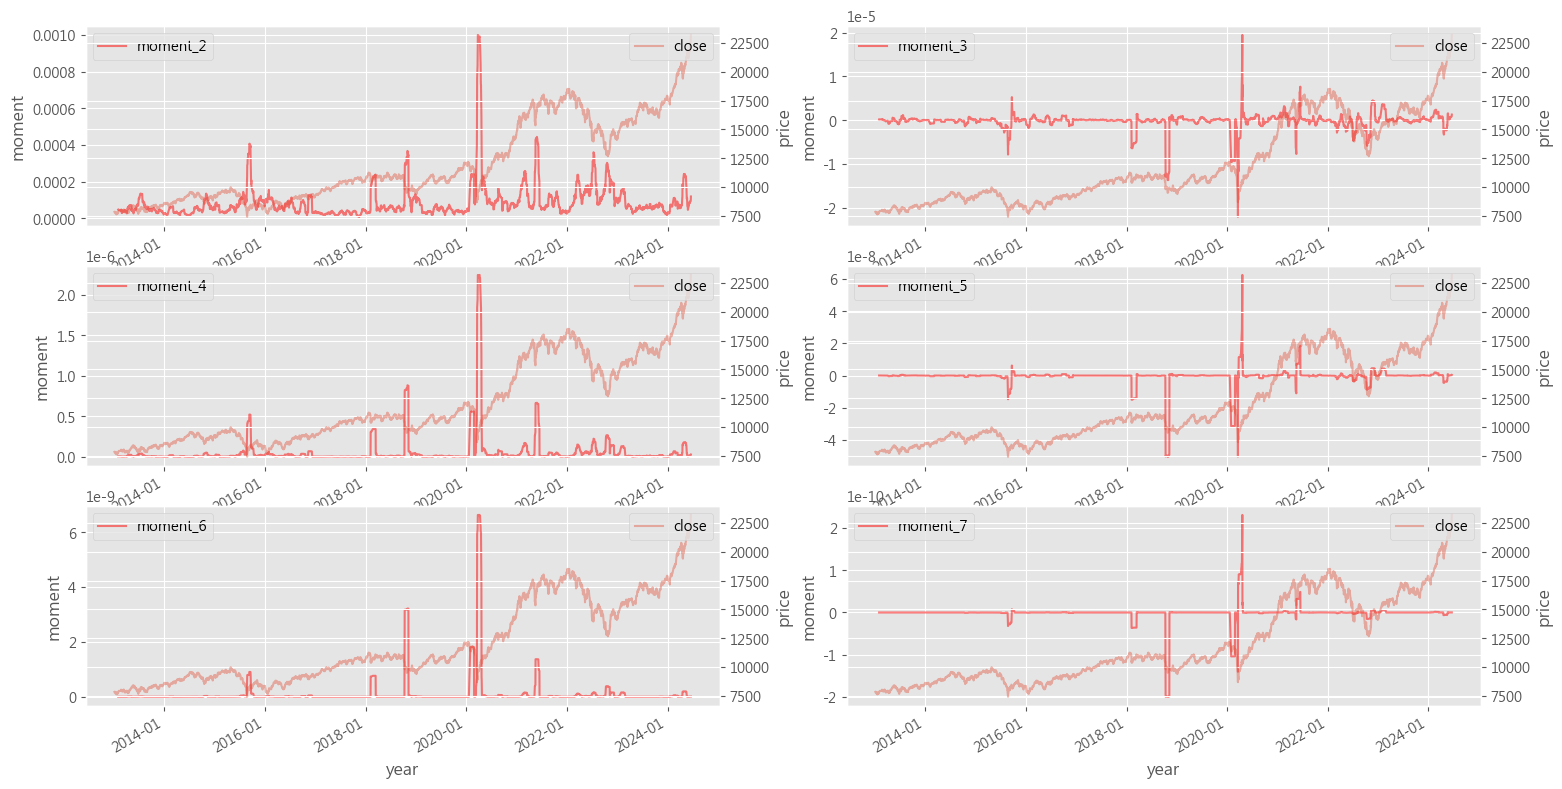

In [7]:
# 查看
plot_twin(temp_df,3,2)

# function 

In [9]:
def getHighMoment(EarnRate, k, N=20):
    """
    計算 N 日滾動窗口內的高階矩，並填充前 N 天的數值
    :param EarnRate: 收益率序列
    :param k: 高階矩的階數
    :param N: 滾動窗口大小，默認為 20
    :return: 填充後的高階矩序列
    """
    HighMoment = (EarnRate**k).rolling(window=N).mean()
    # 填充前 N 日的高階矩
    for i in range(1, N-1):
        HighMoment[i] = (EarnRate[:i+1]**k).mean()
        
    return HighMoment.fillna(0)

def getEMA(moment, alpha):
    """
    計算指數移動平均 (EMA)
    :param moment: 高階矩序列
    :param alpha: 平滑係數
    :return: EMA 序列
    """
    EMA = pd.DataFrame.ewm(moment, alpha=alpha, adjust=False).mean()
    return EMA

def qiexian(profitrate, EMA):
    """
    根據 EMA 的切線法計算總收益
    :param profitrate: 收益率序列
    :param EMA: 指數移動平均序列
    :return: 總收益
    """
    flag = np.zeros(len(profitrate))
    for i in range(1, len(profitrate)):
        if EMA[i - 1] > EMA[i - 2]:  # EMA 上升
            flag[i] = 1
        else:  # EMA 下降
            flag[i] = -1
    strategy_rate = profitrate * flag  # 計算策略收益率
    totalprofit = sum(strategy_rate)  # 總收益

    return totalprofit

def BuySell(profitrate, Moment, EMA):
    """
    根據收益率和 EMA 計算策略收益
    :param profitrate: 收益率序列
    :param Moment: 高階矩序列
    :param EMA: 指數移動平均序列
    :return: 策略的累計收益率、交易次數、總收益、持倉狀態、夏普比率、最大回撤
    """
    flag = np.zeros(len(profitrate))  # 每天的持倉狀態：1 表示多頭，-1 表示空頭，0 表示平倉
    cumrate = np.ones(len(profitrate))  # 累計收益率
    lossflag = 0  # 單次擇時損失，超過 10% 時平倉
    flagloss = 0  # 單次損失超過 10% 時的信號方向
    alpha_all = np.arange(0.05, 0.51, 0.05)  # 所有可能的 alpha 值

    for i in range(2, len(profitrate)):
        # 每隔 90 天重新計算最優 alpha
        if i % 90 == 0:
            cumrate_all = [
                qiexian(list(profitrate[i - 90:i]),
                        getEMA(Moment, alpha_all[j])[i - 90:i].values)
                for j in range(len(alpha_all))
            ]
            # 選擇 90 天內累計收益最大的 alpha，並計算對應的 EMA
            alpha = alpha_all[np.argmax(cumrate_all)]
            EMA = getEMA(Moment, alpha)

        # 若單次損失超過 10%，平倉
        if lossflag < -0.1:
            flag[i] = 0
            flagloss = flag[i - 1]
            lossflag = 0
            continue

        # 若 EMA 上升且未處於虧損狀態，則持多頭
        if EMA[i - 1] - EMA[i - 2] > 0 and flagloss != 1:
            flag[i] = 1
            flagloss = 0

        # 若 EMA 下降且未處於虧損狀態，則持空頭
        if EMA[i - 1] - EMA[i - 2] < 0 and flagloss != -1:
            flag[i] = -1
            flagloss = 0

        # 若持倉狀態不變，更新損失狀態
        if flag[i] == flag[i - 1]:
            lossflag = lossflag + profitrate[i] * flag[i]
            lossflag = min(lossflag, 0)  # 若持續虧損，記錄損失
        else:
            lossflag = 0  # 持倉改變，重置損失

    # 計算策略收益率
    strategy_rate = profitrate * flag
    nav = (1 + strategy_rate).cumprod()
    cumrate = nav - 1  # 累計收益率
    totalprofit = nav[len(nav) - 1] - 1  # 總收益

    # 計算交易次數
    num = 0
    for i in range(len(flag) - 1):
        if flag[i + 1] != flag[i]:
            num += 1

    # 計算夏普比率和最大回撤
    Sharp = strategy_rate.mean() / strategy_rate.std() * 250**0.5
    MDD = max(1 - nav / nav.cummax())

    return cumrate, num, totalprofit, flag, Sharp, MDD


# 5階簡單擇時

In [10]:
def cal_ema(arr,alpha):
    series = pd.Series(arr)
    return series.ewm(alpha=alpha,adjust=False).mean().iloc[-1]

In [30]:
# 選取五階矩作為信號
ema_window = 90
alpha = ema_window + 1
# singal_series = temp_df['moment_5'].ewm(alpha=2/alpha,adjust=False).mean()
singal_series = temp_df['moment_3'].rolling(ema_window).apply(cal_ema, kwargs={'alpha': 2/alpha}, raw=False)
# 獲取前一天的信號
per_singal = singal_series.shift(1)
# 當前信號大於上一日信號
cond = singal_series > per_singal

# 獲取持倉信號

def get_position(ret: pd.Series, cond: pd.Series) -> pd.DataFrame:
    """
    根據收益率和信號計算持倉狀態
    :param ret: 收益率序列
    :param cond: 信號序列
    :return: 包含持倉狀態的 DataFrame
    """
    df = pd.concat([ret, cond], axis=1)  # 合併收益率與信號
    df.columns = ['ret', 'cond']
    
    position = []  # 儲存持倉信號，1 表示持倉，0 表示空倉
    for idx, row in df.iterrows():
        
        if position:
            # 當天出現開倉信號，且上一日為空倉
            if row['cond'] and position[-1] == 0:
                position.append(1)
            
            # 當天有開倉信號，且上一日有持倉，且收益率未達到止損線
            elif row['cond'] and position[-1] == 1 and row['ret'] >= -0.1:
                position.append(1)
            
            else:
                position.append(0)
        else:
            # 初始情況，當天出現開倉信號
            if row['cond']:
                position.append(1)
            else:
                position.append(0)
    
    df['position'] = position  # 將持倉信號加入 DataFrame
    
    return df

# 計算策略收益
algorithm_return = get_position(ret, cond)

# 將持倉收益延後一天，與信號同步
algorithm_return = algorithm_return['ret'].shift(-1) * algorithm_return['position']

# 計算策略累計收益率
cum = (1 + algorithm_return).cumprod()

# 計算基準累計收益率
benchmark = (1 + ret).cumprod()


<Axes: title={'center': '高階動差擇時'}, xlabel='datetime'>

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 38542 (\N{CJK UNIFIED IDEOGRAPH-968E}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 25799 (\N{CJK UNIFIED IDEOGRAPH-64C7}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26178 (\N{CJK UN

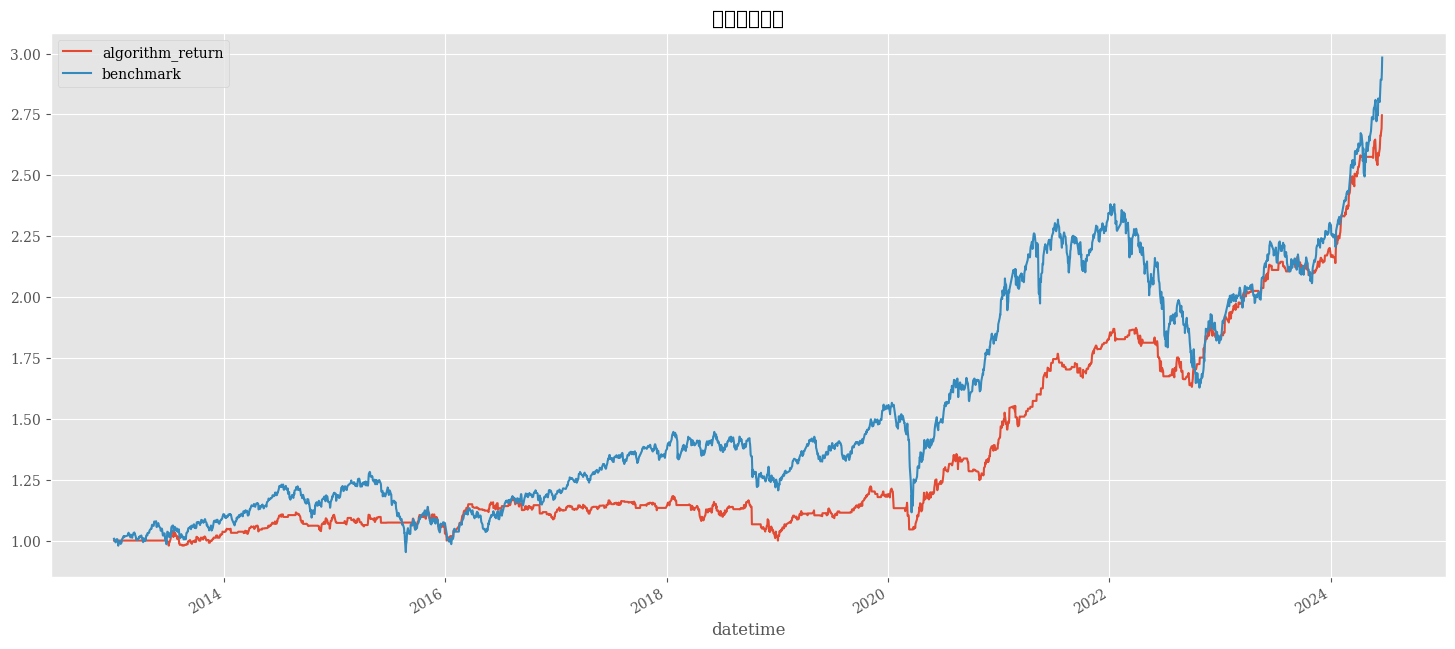

In [31]:
# 高階動差淨值

pd.DataFrame({'algorithm_return':cum,'benchmark':benchmark}).plot(title='高階動差擇時',figsize=(18,8))

# EMA擇時

In [35]:
# pandas + 單次迴圈計算
## 設置五階矩的計算窗口大小 cal_momentt_window = 20
## 設置外推窗口大小 rolling_window = 90
# 指數的起始日期 2013-01-03

cal_momentt_window = 20
rolling_window = 90

end_date = '2024-06-19'  # 回測截止日期

price_data = price_df.copy()

# 計算每日收益率
ret_df = price_data.pct_change()
ret_df.rename(columns={'close': 'ret'}, inplace=True)

# 計算五階矩
momentt = ret_df['ret'].rolling(cal_momentt_window).apply(
    cal_moment, kwargs={'Order': 3}, raw=False)

# 設定 alpha 的取值範圍（指數平滑係數）
alpha = np.arange(0.05, 0.55, step=0.05)

# 計算不同 alpha 對應的 EMA（指數移動平均）
ema_momentt = pd.concat(
    [momentt.ewm(alpha=x, adjust=False).mean() for x in alpha], axis=1)

ema_momentt.columns = alpha  # 將每個 alpha 設為列名

# 每一期的信號由前一期的 EMA 變化產生
diff_ema = ema_momentt.diff().shift(1)

# 計算各個 alpha 的 90 日累計收益
## 條件：大於 0 表示多頭，小於 0 表示空頭
## 邏輯等價於 EMA_{t-1} > EMA_{t-2} 多頭，反之空頭
cond = ((diff_ema > 0) * 1 + (diff_ema < 0) * -1)

cum90rate = cond * np.broadcast_to(
    np.expand_dims(ret_df['ret'].values, axis=1), diff_ema.shape)

# 計算 90 日的累計收益
cum90rate = cum90rate.fillna(0).rolling(rolling_window).sum()

# 去除前 20 日的高階矩（因計算需要更多數據）
slice_ret = ret_df['ret'].iloc[cal_momentt_window:]
slice_momentt = momentt.iloc[cal_momentt_window:]
slice_ema = ema_momentt.iloc[cal_momentt_window:]
slice_diff_ema = diff_ema.iloc[cal_momentt_window:]
slice_cum90rate = cum90rate.iloc[cal_momentt_window:]

lossflag = 0  # 用於記錄單次虧損的累計值
loss_position = 0  # 記錄發生虧損時的持倉方向

flag = np.zeros(len(slice_ret))  # 記錄每日的持倉：1 表示多頭，0 表示空倉，-1 表示空頭

set_alpha = 0.4  # 初始的 alpha 值

for i in range(1, len(slice_ret)):

    # 每 90 天重新選擇最優的 alpha
    if i % 90 == 0:
        set_alpha = slice_cum90rate.iloc[i].idxmax()

    # 如果累計虧損超過 10%，則空倉
    if lossflag < -0.1:
        flag[i] = 0  # 發生虧損後，本日空倉
        loss_position = flag[i - 1]  # 記錄虧損發生時的持倉方向
        lossflag = 0  # 清空累計虧損數據
        continue  # 跳過當前迴圈

    # 當前信號為多頭，且之前虧損方向不是多頭
    if slice_diff_ema[set_alpha].iloc[i] > 0 and loss_position != 1:
        flag[i] = 1
        loss_position = 0

    # 當前信號為空頭，且之前虧損方向不是空頭
    if slice_diff_ema[set_alpha].iloc[i] < 0 and loss_position != -1:
        flag[i] = -1
        loss_position = 0

    # 若當日持倉狀態與前一日相同，累計虧損
    if flag[i] == flag[i - 1]:
        lossflag = lossflag + flag[i] * slice_ret[i]
        lossflag = min(lossflag, 0)  # 虧損不可能為正值
    else:
        lossflag = 0  # 若持倉改變，重置虧損

# 計算策略收益率
strategy_rate = slice_ret * flag

# 計算策略的累計收益率
nav = (1 + strategy_rate).cumprod()


C:\Users\User\AppData\Local\Temp\ipykernel_20628\2046320415.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lossflag = lossflag + flag[i] * slice_ret[i]
C:\Users\User\AppData\Local\Temp\ipykernel_20628\2046320415.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lossflag = lossflag + flag[i] * slice_ret[i]
C:\Users\User\AppData\Local\Temp\ipykernel_20628\2046320415.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lossfla

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from current font.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20934 (\N{CJK UN

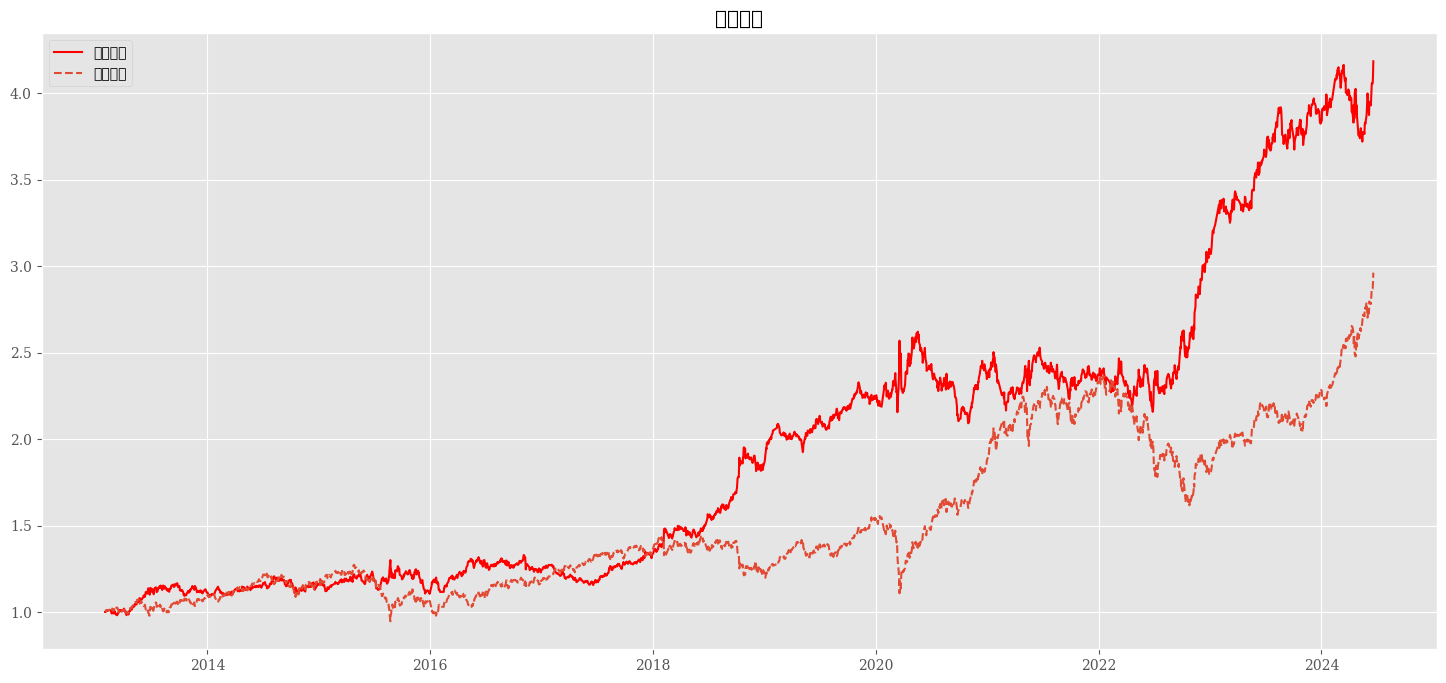

In [36]:

plt.figure(figsize=(18,8))
plt.title('策略净值')
plt.plot(nav,label='策略净值',c='r')
plt.plot((1+slice_ret).cumprod(),label='基准净值',ls='--')
plt.legend()